In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [66]:
import numpy as np
from scipy.stats import norm

In [21]:
from keras.layers import Input, Dense, Lambda, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras import objectives

### References :
##### Auto-Encoding Variational Bayes : https://arxiv.org/abs/1312.6114
##### Tutorial from Oliver Durr : https://home.zhaw.ch/~dueo/bbs/files/vae.pdf
##### Building autoencoders in keras : https://blog.keras.io/building-autoencoders-in-keras.html

In [11]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Variational Auto-Encoder

In [12]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim1 = 500
intermediate_dim2 = 500
nb_epoch = 25
epsilon_std = 1.0

In [22]:
x = Input(batch_shape=(batch_size, original_dim))
h1 = Dense(intermediate_dim1, activation='softplus')(x)
h2 = Dense(intermediate_dim2, activation='softplus')(h1)
z_mean = Dense(latent_dim, activation=None)(h2)
z_log_var = Dense(latent_dim, activation=None)(h2)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h1 = Dense(intermediate_dim1, activation='softplus')
decoder_h2 = Dense(intermediate_dim2, activation='softplus')
decoder_proba = Dense(original_dim, activation='sigmoid')
h1_decoded = decoder_h1(z)
h2_decoded = decoder_h2(h1_decoded)
x_decoded_proba = decoder_proba(h2_decoded) # a Bernoulli dist. has a single prob. parameter


def vae_loss(x, x_decoded_proba):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_proba)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_proba)
vae.compile(optimizer=Adam(1e-3), loss=vae_loss)

In [67]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch, # may have to increase this value
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 5s - loss: 139.5490 - val_loss: 143.8456
Epoch 2/25
60000/60000 [==============================] - 5s - loss: 139.5299 - val_loss: 143.5871
Epoch 3/25
60000/60000 [==============================] - 5s - loss: 139.3639 - val_loss: 143.7198
Epoch 4/25
60000/60000 [==============================] - 5s - loss: 139.2966 - val_loss: 143.5319
Epoch 5/25
60000/60000 [==============================] - 5s - loss: 139.2536 - val_loss: 143.2391
Epoch 6/25
60000/60000 [==============================] - 5s - loss: 139.1557 - val_loss: 144.1682
Epoch 7/25
60000/60000 [==============================] - 5s - loss: 139.0759 - val_loss: 143.6369
Epoch 8/25
60000/60000 [==============================] - 5s - loss: 139.0191 - val_loss: 143.3952
Epoch 9/25
60000/60000 [==============================] - 5s - loss: 139.0268 - val_loss: 143.2682
Epoch 10/25
60000/60000 [==============================] - 

In [68]:
# build a model to project inputs on the latent space
encoder_mean = Model(x, z_mean)
#encoder_stdev = Model(x, K.exp(z_log_var / 2))

#encoder = Model(x, z)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h1_decoded = decoder_h1(decoder_input)
_h2_decoded = decoder_h2(_h1_decoded)
_x_decoded_proba = decoder_proba(_h2_decoded)
generator = Model(decoder_input, _x_decoded_proba)

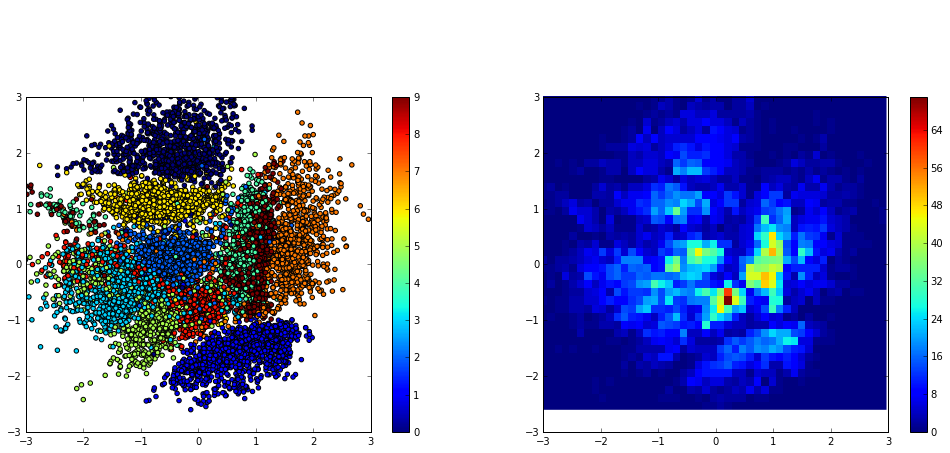

In [74]:
# display a 2D plot of the digit classes in a 2D projection of the latent space
x_test_encoded = encoder_mean.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.subplot(1,2,2)
plt.hist2d(x_test_encoded[:,0], x_test_encoded[:,1], (50, 50), cmap=plt.cm.jet)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.colorbar()

### Note that the above should be close to a spherical gaussian distribution

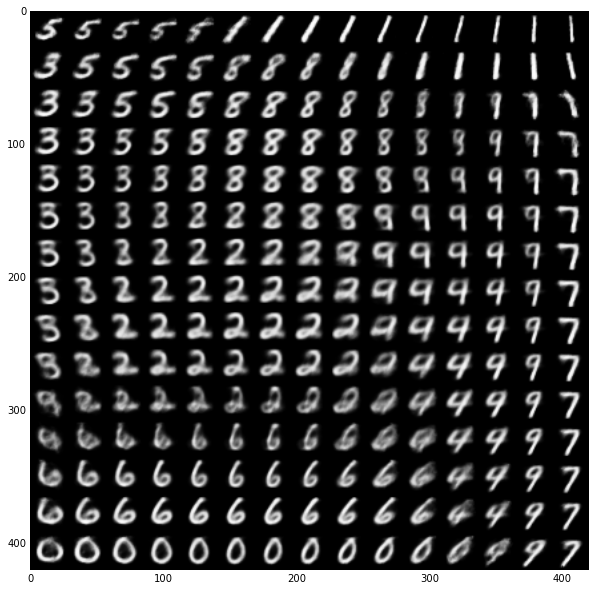

In [70]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Reconstruction of Input data (can add noise)

In [71]:
noise_factor = 0#.05
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [72]:
encoded_noisy_imgs = encoder_mean.predict(x_test_noisy)
decoded_noisy_imgs = generator.predict(encoded_noisy_imgs)

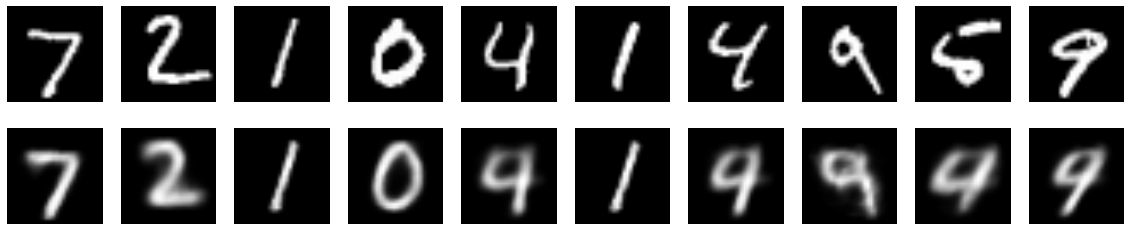

In [73]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()